# PyTorch 3DCNN Classfication (Subject Base data Splitting)
This notebook using PyTorch and cudaGPU.

In [1]:
import os
import pandas as pd
import numpy as np
import nibabel as nib
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"decive: {device}")

decive: cuda


# 讀取數據

In [3]:
csv_path = 'structured_data_mac.csv'
df = pd.read_csv(csv_path)

# 檢查並清理數據

In [4]:
if df['Group'].isnull().any():
    df = df.dropna(subset=['Group'])

# 檢查是否存在非預期的標籤值

In [5]:
expected_labels = ['CN', 'MCI', 'AD']
df = df[df['Group'].isin(expected_labels)]

image_paths = df['Image Path'].tolist()

# 將標籤映射為數字

In [6]:
label_mapping = {'CN': 0, 'MCI': 1, 'AD': 2}
labels = df['Group'].map(label_mapping).tolist()

# 獲取個別的病人ID

In [7]:
unique_patients = df['Subject'].unique()

# 根據病人ID進行訓練和驗證分割

In [8]:
train_ids, val_ids = train_test_split(unique_patients, test_size=0.2, random_state=42)

# 創建訓練和驗證DataFrame

In [9]:
train_df = df[df['Subject'].isin(train_ids)]
val_df = df[df['Subject'].isin(val_ids)]

# 提取訓練和驗證影像路徑和標籤

In [10]:
train_paths = train_df['Image Path'].tolist()
train_labels = train_df['Group'].map(label_mapping).tolist()
val_paths = val_df['Image Path'].tolist()
val_labels = val_df['Group'].map(label_mapping).tolist()

# 將標籤轉換為 tensor

In [11]:
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)

In [12]:
# Define the PyTorch dataset class
class NiftiDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        nifti_path = self.image_paths[idx]
        label = self.labels[idx]
        nifti_image = nib.load(nifti_path)
        image = nifti_image.get_fdata()
        image = np.resize(image, (96, 96, 96))
        image = torch.tensor(image, dtype=torch.float32)
        image = image.unsqueeze(0)  # Add channel dimension
        return image, label

In [13]:
# Create dataset instances
train_dataset = NiftiDataset(train_paths, train_labels_tensor)
val_dataset = NiftiDataset(val_paths, val_labels_tensor)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# 3D CNN 模型架構定義
## 模型組件
- **輸入卷積層**：這個初始層接受單通道輸入，應用 3D 卷積，然後進行批次歸一化和 ELU 激活。它擴展了通道維度以匹配後續層的輸入要求。

- **Block-A**：
  - 一系列卷積層，每個層後面跟著批次歸一化、ELU 激活和最大池化。
  - 這個塊中的卷積層保持相同數量的通道，但通過池化減少空間維度。
  - 旨在從輸入數據中提取特徵並進行降採樣。

- **重複的 Block-A**：
  - Block-A 被多次重複（在此例中為 5 次），以進一步處理和降低數據維度。
  - 每次重複都進一步提取特徵並減少空間維度。

- **Block-B**：
  - 一系列全連接層，處理最後一個重複的 Block-A 的展平輸出。
  - 包含用於正規化的 dropout 以及最終的 softmax 分類層。

### 前向傳播
- 數據通過輸入卷積層，然後進行 Block-A 的重複應用。
- 在 Block-A 的最後一次重複後，數據被展平並通過 Block-B 進行最終處理和分類。

In [14]:
class ModifiedConv3DNet(nn.Module):
    def __init__(self):
        super(ModifiedConv3DNet, self).__init__()

        # Input Convolution Layer
        self.input_conv = nn.Sequential(
            nn.Conv3d(in_channels=1, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm3d(num_features=256),
            nn.ELU(alpha=1),
            nn.Conv3d(in_channels=256, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm3d(num_features=64),
        )
        
        # Block-A
        self.block_a = nn.Sequential(
            nn.Conv3d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm3d(num_features=64),
            nn.ELU(alpha=1),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )
        

        
        # Replicate Block-A 5 times
        self.repeated_block_a = nn.Sequential(*[self.block_a for _ in range(5)])
        
        # 計算 flattened_size
        D, H, W = 96, 96, 96  # 輸入尺寸
        for _ in range(5):  # 經過 5 次池化
            D, H, W = D // 2, H // 2, W // 2
        flattened_size = 64 * D * H * W

        # Block-B
        self.block_b = nn.Sequential(
            nn.Linear(in_features=flattened_size, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=3),
            nn.Dropout(p=0.1),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        # Apply input convolution layer
        x = self.input_conv(x)

        # Apply repeated Block-A
        x = self.repeated_block_a(x)
        
        # Flatten the tensor for the dense layers in Block-B
        x = torch.flatten(x, 1)
        
        # Apply Block-B
        x = self.block_b(x)
        
        return x


# Initialize the model

In [15]:
model = ModifiedConv3DNet().to('cuda')
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練與驗證 3D CNN 模型

此代碼塊主要用於訓練和驗證一個三維卷積神經網路（3D CNN）模型。模型被訓練來處理醫學影像數據，並在20個週期（epochs）內進行迭代訓練和驗證。

## 訓練過程

- 每個週期開始時，模型設定為訓練模式。
- 數據被加載並分批（通過 `train_loader`）傳遞到模型中。
- 對於每一批數據，模型首先在GPU上進行計算（`.to('cuda')`），然後進行前向傳播，計算損失，並進行反向傳播更新模型參數。
- 訓練損失被累加，用於後續計算整個週期的平均訓練損失。
- 同時，模型預測和真實目標被收集，用於計算訓練準確度和F1分數。

## 驗證過程

- 在每個訓練週期後，模型切換到評估模式。
- 使用不參與訓練的驗證數據集（通過 `val_loader` 加載）來評估模型的性能。
- 在這個階段，不進行梯度計算（`torch.no_grad()`），以減少內存使用並加速處理。
- 驗證損失、驗證準確度和驗證F1分數被計算，以評估模型在未見數據上的表現。

## 保存模型和早期停止

- 如果在某個週期的驗證損失比之前所有週期都低，或者驗證準確度有提高，則保存該模型。
- 兩種不同的保存策略：一種基於最低驗證損失（`Subject_based_Splitting_3DCNN_pytorch_model_min_loss.pth`），另一種基於最高驗證準確度（`Subject_based_Splitting_3DCNN_pytorch_model_max_accuracy.pth`）。
- 如果連續多個週期沒有改善（在這個例子中是超過3個週期），則實行早期停止，以防止過擬合。

## 性能輸出

- 每個週期結束時，打印訓練和驗證損失，以及準確度和F1分數，以便於追蹤模型的學習進度和性能。



In [16]:
epochs = 20
best_val_loss = float('inf')
patience = 0
best_val_accuracy = 0.0

# 初始化用於繪圖的列表
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
# 訓練階段
    model.train()
    train_loss = 0.0
    all_train_preds = []
    all_train_targets = []
    for images, targets in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
        images = images.to('cuda')
        targets = targets.to('cuda')
        optimizer.zero_grad()
        outputs = model(images)
        loss = torch.nn.functional.cross_entropy(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # 收集預測和目標
        preds = torch.argmax(outputs, dim=1)
        all_train_preds.extend(preds.cpu().numpy())
        all_train_targets.extend(targets.cpu().numpy())

    # 驗證階段
    model.eval()
    val_loss = 0.0
    all_val_preds = []
    all_val_targets = []
    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
            images = images.to('cuda')
            targets = targets.to('cuda')
            outputs = model(images)
            loss = torch.nn.functional.cross_entropy(outputs, targets)
            val_loss += loss.item()

            # 收集預測和目標
            preds = torch.argmax(outputs, dim=1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_targets.extend(targets.cpu().numpy())

    # 計算準確度和 F1 分數
    train_accuracy = accuracy_score(all_train_targets, all_train_preds)
    train_f1 = f1_score(all_train_targets, all_train_preds, average='weighted')
    val_accuracy = accuracy_score(all_val_targets, all_val_preds)
    val_f1 = f1_score(all_val_targets, all_val_preds, average='weighted')

    # 計算並儲存每次迭代的損失和準確率
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader)}, Validation Loss: {val_loss / len(val_loader)}")
    print(f"Training Accuracy: {train_accuracy}, Training F1: {train_f1}")
    print(f"Validation Accuracy: {val_accuracy}, Validation F1: {val_f1}")

    # 保存模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'EnhancedFeatureNet_min_loss.pth')
        patience = 0
    elif val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'EnhancedFeatureNet_max_accuracy.pth')
        patience = 0
    else:
        patience += 1

    # 早期停止
    if patience > 3:
        print("Stopping early due to no improvement in validation loss.")
        break

Validation Epoch 1/20: 100%|██████████| 161/161 [18:20<00:00,  6.84s/it]


Epoch 1, Train Loss: 1.037518028099582, Validation Loss: 0.928638942493415
Training Accuracy: 0.4950806768988587, Training F1: 0.3681045429959004
Validation Accuracy: 0.6111975116640747, Validation F1: 0.47904669833130165


Validation Epoch 2/20: 100%|██████████| 161/161 [19:48<00:00,  7.38s/it]


Epoch 2, Train Loss: 1.020060878317311, Validation Loss: 0.9214749587989002
Training Accuracy: 0.51357733175915, Training F1: 0.41584411614176897
Validation Accuracy: 0.6314152410575428, Validation F1: 0.48875993874044293


Validation Epoch 3/20: 100%|██████████| 161/161 [17:02<00:00,  6.35s/it]


Epoch 3, Train Loss: 1.0043710868501063, Validation Loss: 0.9333446036954844
Training Accuracy: 0.5175127902400629, Training F1: 0.44650918888677377
Validation Accuracy: 0.5847589424572317, Validation F1: 0.4908645661989531


Validation Epoch 4/20: 100%|██████████| 161/161 [17:00<00:00,  6.34s/it]


Epoch 4, Train Loss: 0.9855154402226022, Validation Loss: 0.9659411048296815
Training Accuracy: 0.5446674537583629, Training F1: 0.4813527618700461
Validation Accuracy: 0.5614307931570762, Validation F1: 0.5285198123312123


Validation Epoch 5/20: 100%|██████████| 161/161 [17:28<00:00,  6.52s/it]


Epoch 5, Train Loss: 0.9593077288858546, Validation Loss: 0.9308994238421043
Training Accuracy: 0.5816607634789452, Training F1: 0.514928338097397
Validation Accuracy: 0.6111975116640747, Validation F1: 0.509103296546293


Validation Epoch 6/20: 100%|██████████| 161/161 [22:21<00:00,  8.33s/it]


Epoch 6, Train Loss: 0.9398650007802736, Validation Loss: 0.9463955260211636
Training Accuracy: 0.5977961432506887, Training F1: 0.5341136528311794
Validation Accuracy: 0.6034214618973561, Validation F1: 0.5529245946895072


Validation Epoch 7/20: 100%|██████████| 161/161 [16:34<00:00,  6.18s/it]


Epoch 7, Train Loss: 0.9177644083147529, Validation Loss: 0.9213957838390184
Training Accuracy: 0.6229830775285321, Training F1: 0.5575103648270151
Validation Accuracy: 0.6158631415241057, Validation F1: 0.5125710494386737


Validation Epoch 8/20: 100%|██████████| 161/161 [17:19<00:00,  6.46s/it]


Epoch 8, Train Loss: 0.8888017514591697, Validation Loss: 0.9888304057328597
Training Accuracy: 0.6587957497048406, Training F1: 0.590822831837631
Validation Accuracy: 0.5303265940902022, Validation F1: 0.49176589502803253


Validation Epoch 9/20: 100%|██████████| 161/161 [16:38<00:00,  6.20s/it]


Epoch 9, Train Loss: 0.8645194471819596, Validation Loss: 0.9528066952776465
Training Accuracy: 0.6812278630460449, Training F1: 0.6115476074298534
Validation Accuracy: 0.5847589424572317, Validation F1: 0.5232774178524796


Validation Epoch 10/20: 100%|██████████| 161/161 [16:37<00:00,  6.19s/it]


Epoch 10, Train Loss: 0.8561610352693114, Validation Loss: 0.9836903184837436
Training Accuracy: 0.6914600550964187, Training F1: 0.6212853749813393
Validation Accuracy: 0.5614307931570762, Validation F1: 0.5285731193207938


Validation Epoch 11/20: 100%|██████████| 161/161 [16:37<00:00,  6.20s/it]

Epoch 11, Train Loss: 0.8361342868902398, Validation Loss: 0.9508344083098892
Training Accuracy: 0.7119244391971665, Training F1: 0.6404728877063277
Validation Accuracy: 0.5816485225505443, Validation F1: 0.5219990296529421
Stopping early due to no improvement in validation loss.


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

precision = precision_score(y_test, y_pred, average='weighted')
print(f'Precision: {precision:.2f}')

recall = recall_score(y_test, y_pred, average='weighted')
print(f'Recall: {recall:.2f}')

f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 Score: {f1:.2f}')


Accuracy: 0.80
Precision: 0.66
Recall: 0.80
F1 Score: 0.72


c:\Users\MR600\anaconda3\envs\ML_PY310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


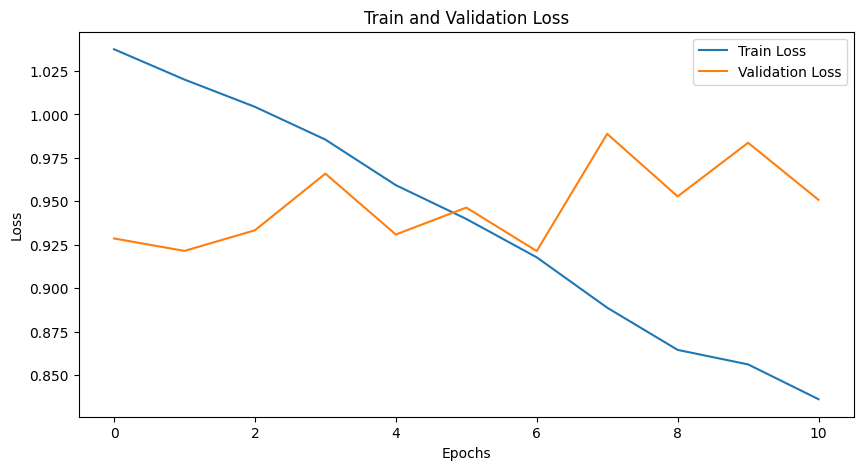

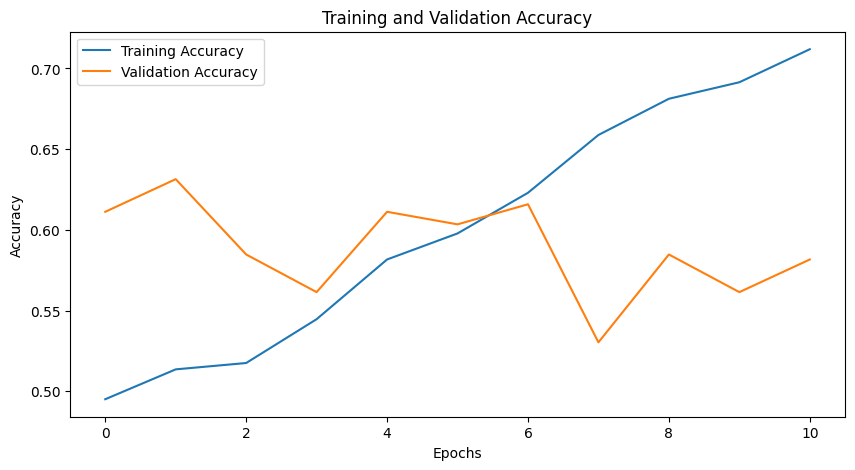

In [17]:
# 繪製損失圖
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 繪製準確率圖
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()